In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from scipy.stats import mstats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report   

In [146]:
iris_df = pd.read_csv('iris.csv')
iris_df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [49]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


## IRIS EDA & Feature Engineering

In [163]:
# get the summary statistics for the numerical columns
iris_df.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667,0.666667
std,43.445368,0.828066,0.433594,1.764420,0.763161,0.472984
min,1.000000,4.300000,2.000000,1.000000,0.100000,0.000000
25%,38.250000,5.100000,2.800000,1.600000,0.300000,0.000000
50%,75.500000,5.800000,3.000000,4.350000,1.300000,1.000000
75%,112.750000,6.400000,3.300000,5.100000,1.800000,1.000000
max,150.000000,7.900000,4.400000,6.900000,2.500000,1.000000


In [148]:
print(f"Species before mapping: {iris_df['Species'].unique()}")
iris_df['Species'] = iris_df['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 1})
print(f"Species after mapping: {iris_df['Species'].unique()}")

Species before mapping: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
Species after mapping: [0 1]


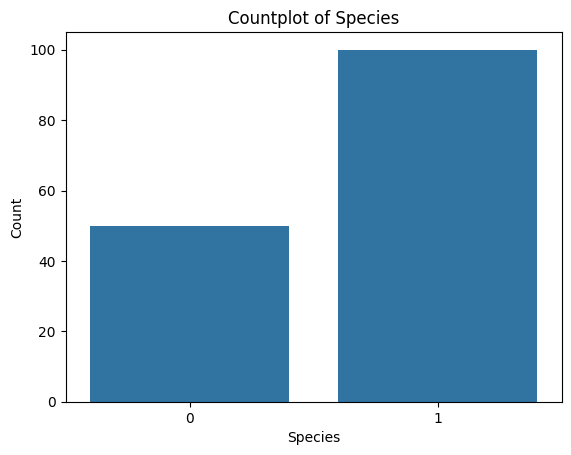

In [149]:
sns.countplot(x='Species', data=iris_df)
plt.title('Countplot of Species')
plt.xlabel('Species')
plt.ylabel('Count')
plt.show()

The data exhibits imbalance within the "Species" category.

In [95]:
iris_df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0


In [96]:
# drop the id column as it doesn't hold meaningful information for our model
iris_df.drop(columns='Id', axis=1, inplace=True)
iris_df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [54]:
# calculate the percentage of missing values per column
missing_data_rows = []
total_rows = len(iris_df)

for num in iris_df.columns:
    missing_values_count = iris_df[num].isnull().sum()
    percentage_missing_per_column = round((missing_values_count / total_rows) * 100)
    missing_data_rows.append({'Feature': num,'Missing Values Count': missing_values_count,'Percentage Missing': f"{percentage_missing_per_column}%"})

# convert the list of dictionaries into a dataFrame
missing_output_df = pd.DataFrame(missing_data_rows)
missing_output_df

,Feature,Missing Values Count,Percentage Missing
0,SepalLengthCm,0,0%
1,SepalWidthCm,0,0%
2,PetalLengthCm,0,0%
3,PetalWidthCm,0,0%
4,Species,0,0%


No missing data to be addressed.

In [110]:
X = iris_df.drop(columns=['Species'], axis=1)  # Independent features
y = iris_df['Species']  # Dependent feature

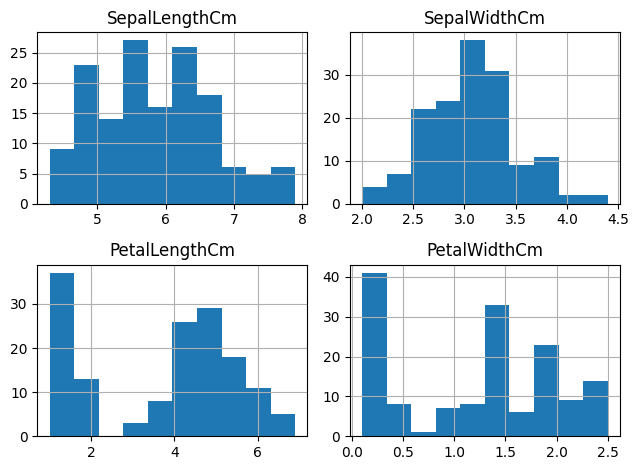

In [22]:
# plot the distributions of features
X.hist()
plt.tight_layout()

The features exhibit non-Gaussian distributions, making MinMaxScaler() the preferred technique to normalize all features and bring them into a similar range of values.

<Axes: >

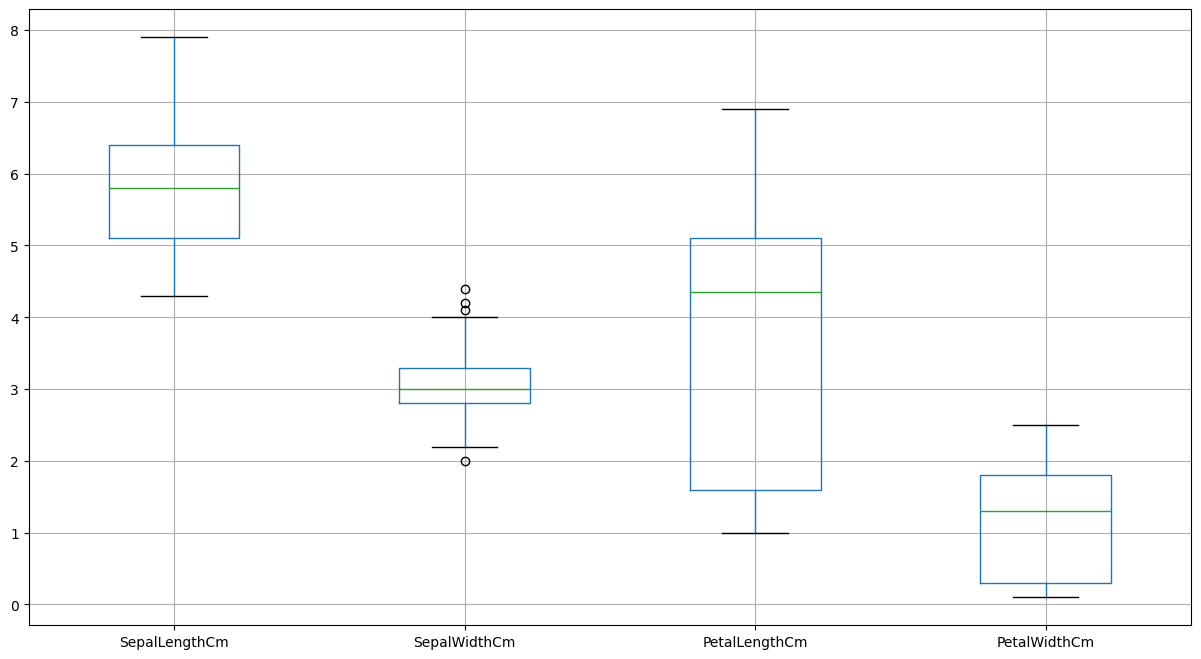

In [23]:
# plot the distributions of features along with their outliers
X.boxplot(figsize=(15, 8))

In [111]:
# Fit the scaler on features
scaler = MinMaxScaler()

# Apply the scaler on features
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

<Axes: >

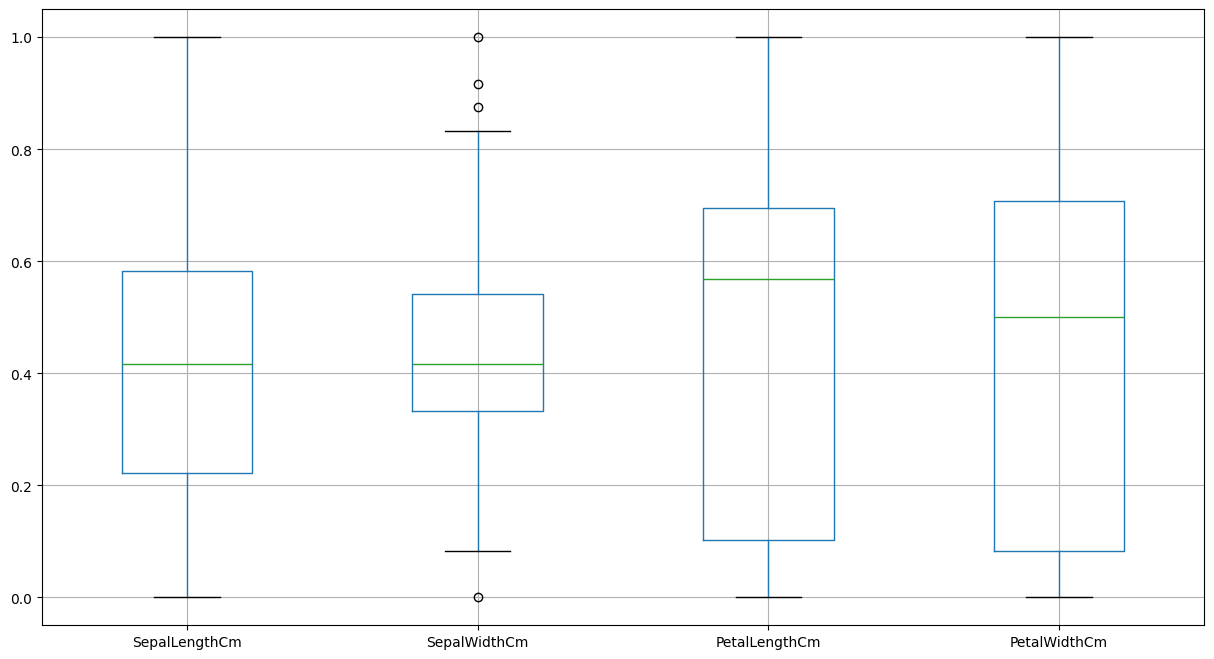

In [112]:
# plot the distribution of the X features after applying the scaler
X.boxplot(figsize=(15, 8))

"SepalWidthCm" exhibits a few outliers that can be addressed with Winsorization.

In [113]:
# apply winsorization to address outliers
X['SepalWidthCm'] = mstats.winsorize(X['SepalWidthCm'], limits=(0.10, 0.10))

<Axes: >

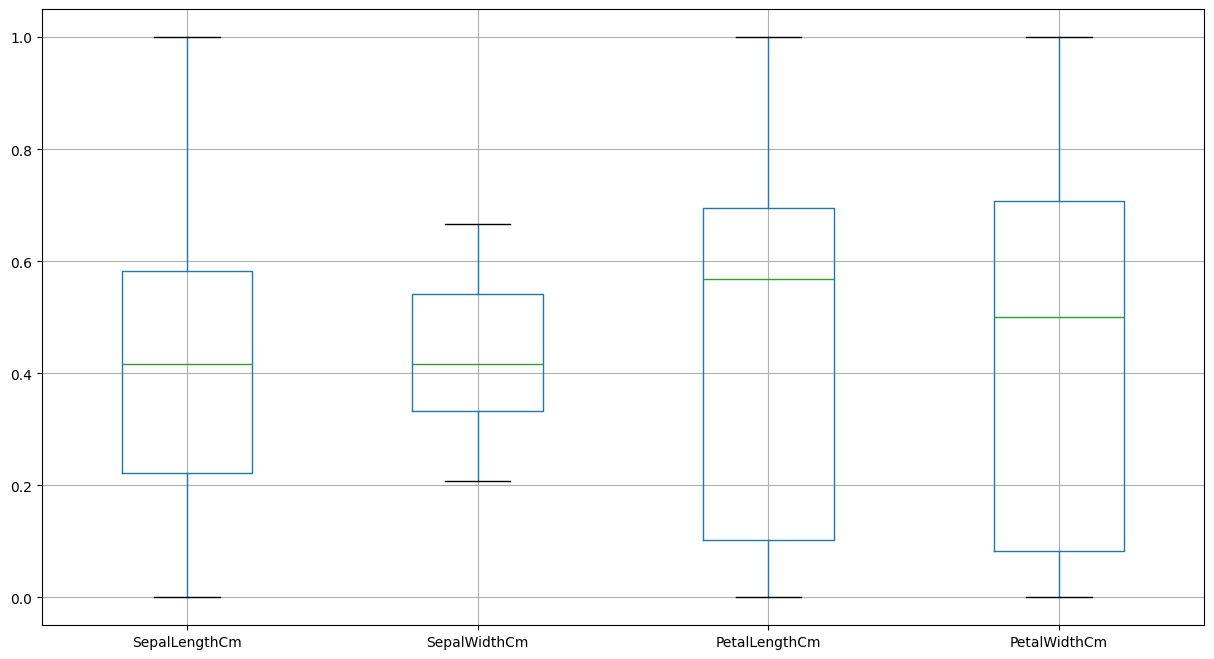

In [114]:
# plot the distribution of the X features after applying winsorization
X.boxplot(figsize=(15, 8))

In [115]:
# concatenate the scaled features with the target variable
X_with_target = pd.concat([y,X], axis=1)

# display the scaled DataFrame
X_with_target.head()

,Species,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,0,0.222222,0.625000,0.067797,0.041667
1,0,0.166667,0.416667,0.067797,0.041667
2,0,0.111111,0.500000,0.050847,0.041667
3,0,0.083333,0.458333,0.084746,0.041667
4,0,0.194444,0.666667,0.067797,0.041667


In [116]:
corr_matrix = X_with_target.corr()
corr_matrix

,Species,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
Species,1.000000,0.717416,-0.616415,0.922688,0.887510
SepalLengthCm,0.717416,1.000000,-0.137214,0.871754,0.817954
SepalWidthCm,-0.616415,-0.137214,1.000000,-0.438497,-0.368018
PetalLengthCm,0.922688,0.871754,-0.438497,1.000000,0.962757
PetalWidthCm,0.887510,0.817954,-0.368018,0.962757,1.000000


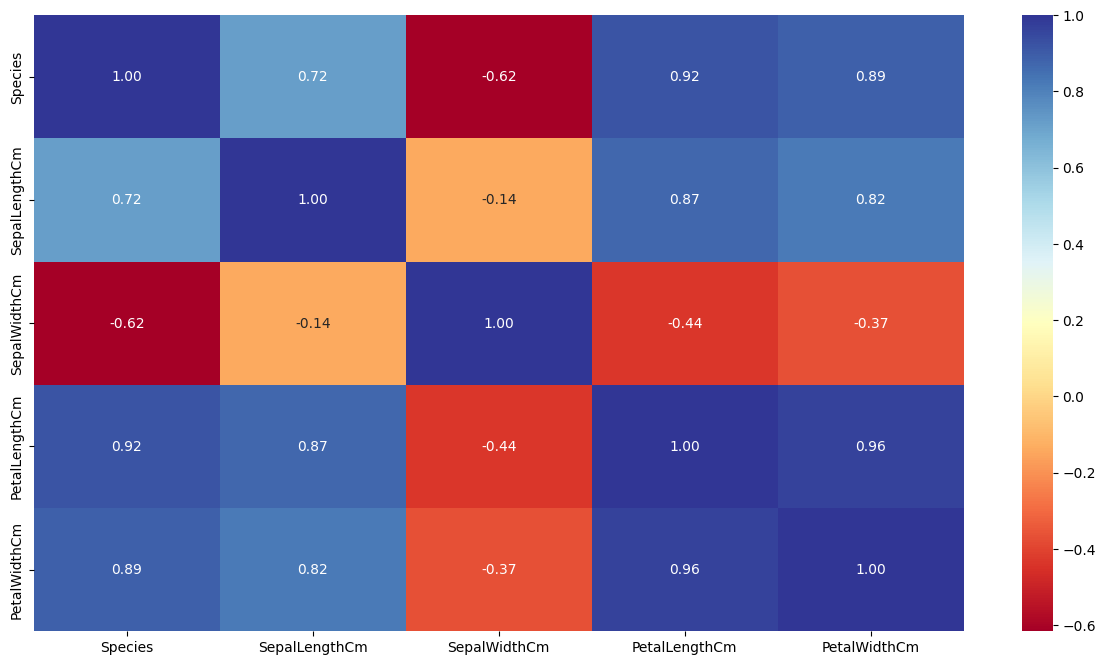

In [136]:
plt.figure(figsize=(15, 8))  # adjust width and height as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdYlBu")
plt.show()

All features exhibit strong correlations with "Species" and are important for the model.

## Build and fit a logistic regression model

In [122]:
X = iris_df.drop(columns=['Species'], axis=1)  # Independent features
y = iris_df['Species']  # Dependent feature

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
# Fit the scaler on train data
scaler = MinMaxScaler()
scaler.fit(X_train)

# Apply the scaler on train and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# convert the scaled data back to a DataFrame
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [126]:
X_train['SepalWidthCm'] = mstats.winsorize(X_train['SepalWidthCm'], limits=(0.10, 0.10))
X_test['SepalWidthCm'] = mstats.winsorize(X_test['SepalWidthCm'], limits=(0.10, 0.10))

In [41]:
# fit a model
log_reg = LogisticRegression()

In [160]:
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
}

# instantiate GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Predictions on the test set
y_pred = best_model.predict(X_test).reshape(-1,1)

/Users/lalehhaidari/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lalehhaidari/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lalehhaidari/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lalehhaidari/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lalehhaidari/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

## Measuring model performance

In [158]:
# Evaluate the model

print(f"Accuracy Score: \n {accuracy_score(y_pred, y_test)}")
print(f"Confusion Matrix: \n {confusion_matrix(y_pred, y_test)}")
print(f"Classification Report: \n {classification_report(y_pred, y_test)}")

Accuracy Score: 
 1.0
Confusion Matrix: 
 [[10  0]
 [ 0 20]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        20

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



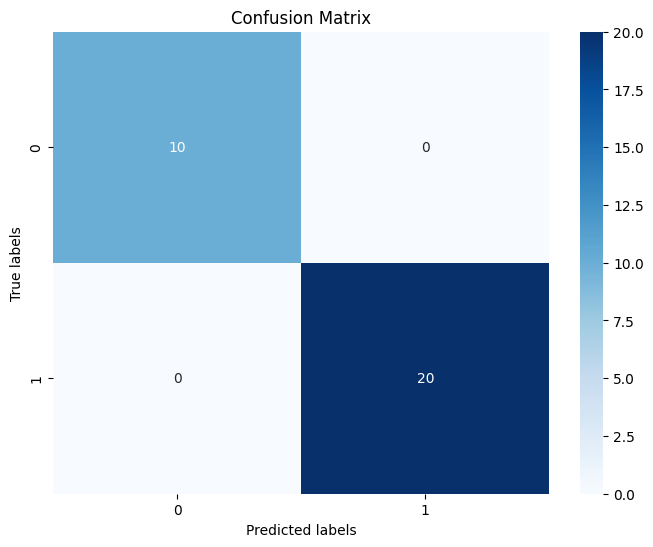

In [159]:
cm = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In the confusion matrix:

- The top-left cell represents the number of samples that were correctly classified as "Iris-setosa" (True Negatives). In this case, there are 10 samples correctly classified.

- The bottom-right cell represents the number of samples that were correctly classified as "Iris-virginica" or "Iris-versicolor" (True Positives). Here, there are 20 samples correctly classified.

Since there are no off-diagonal elements, it indicates that there are no misclassifications in the predictions.

Based on the above analysis:

Since there are no false positives and no false negatives, both precision and recall are likely to be **high**.

In [145]:
# True Positives (TP)
TP = 20

# True Negatives (TN)
TN = 10

# False Positives (FP)
FP = 0

# False Negatives (FN)
FN = 0

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Precision
precision = TP / (TP + FP)

# Recall
recall = TP / (TP + FN)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


The above results should confirm that both precision and recall are high, and the model has achieved perfect accuracy.

An accuracy of 1 for a logistic regression model means that the model has correctly classified all the instances in the dataset. In other words, there are no misclassifications, and the model's predictions perfectly match the true labels in the dataset. Achieving an accuracy of 1 is rare in real-world scenarios and may indicate overfitting to the training data or an issue with the evaluation process, such as data leakage or an imbalanced dataset.

In [161]:
# save the model
dump(best_model, 'iris_log_reg_model.joblib')

['iris_log_reg_model.joblib']

**NOTE 1:** To run the model, access and run **predict_iris_species.ipynb** in the same directory.

**NOTE 2:** the optional task can be found in the **iris_logistic_regression_optional.ipynb** file in the same directory.